In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
from sklearn.externals import joblib
from utility import *
from lane_fitting import *
import os.path as path
import random

%matplotlib inline

# Camera calibration
Calibrate camera using opencv library and test the result.

In [11]:
calibration_file_dir = './camera_cal/'
mtx_path = './mtx.pkl'
dist_path = './dist.pkl'

In [12]:
if path.isfile(mtx_path) and path.isfile(dist_path):
    mtx = joblib.load('./mtx.pkl')
    dist = joblib.load('./dist.pkl')
else:
    mtx, dist = calibrate_from_dir(calibration_file_dir, mtx_path, dist_path)

## visualize undistortion process with checkboard image.

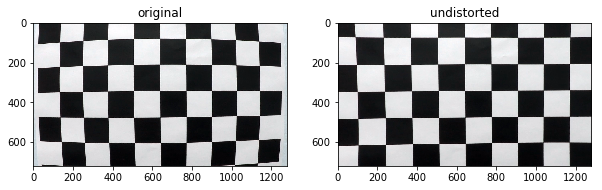

In [13]:
img = cv2.imread(calibration_file_dir+'calibration1.jpg')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,20))
ax1.imshow(img)
ax1.set_title('original')
dst = cv2.undistort(img, mtx, dist, None, mtx)
ax2.set_title('undistorted')
ax2.imshow(dst)

# Perspective transform
Get bird's view of the road from camera image

In [14]:
img_list = sorted(glob.glob('./test_images/*.jpg'))

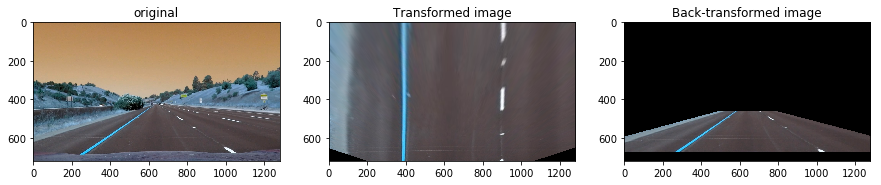

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 30))

img = cv2.imread(img_list[0])
ax1.imshow(img)
ax1.set_title('original')

M, warped = get_birdview(img)
ax2.imshow(warped)
ax2.set_title('Transformed image')

Minv = np.linalg.inv(M)
warpedback = cv2.warpPerspective(warped, Minv, dsize=warped.shape[1::-1])
ax3.imshow(warpedback)
ax3.set_title('Back-transformed image')

# Binarize image by sobel operator and color thresholding

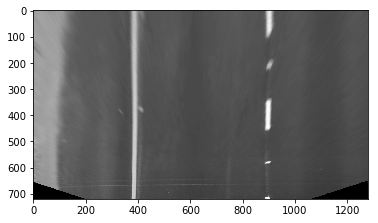

In [16]:
gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, 'gray')

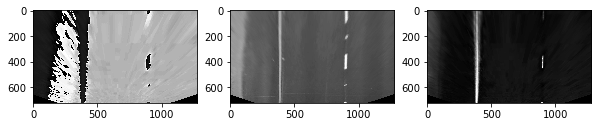

In [17]:
hls = cv2.cvtColor(warped, cv2.COLOR_BGR2HLS)
figure, ax = plt.subplots(1,3, figsize=(10, 30))
for i in range(3):
    ax[i].imshow(hls[..., i], 'gray')

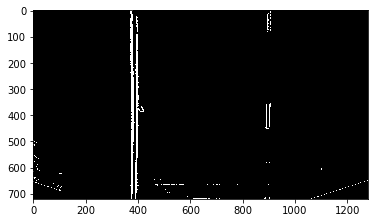

In [18]:
#sobel = abs_sobel_thresh(gray, orient='x', sobel_kernel=5, thresh=(20, 255))
sobel = mag_thresh(gray, thresh=(15, 255))
combined = np.zeros_like(sobel)
combined[(sobel == 1) & (hls[..., 2] >= 15)] = 1
plt.imshow(combined, 'gray')

# Sliding window search and polynomial fitting

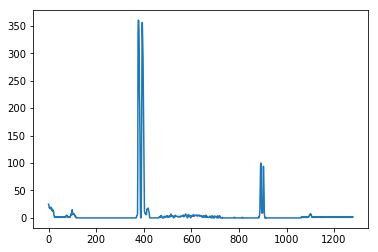

In [19]:
img = combined
histogram = np.sum(img[img.shape[0]//2:, ...], axis=0)
plt.plot(histogram)

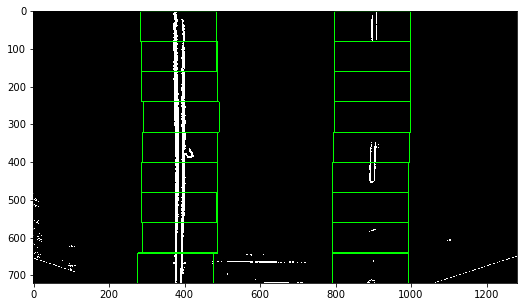

In [20]:
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

left_ys, left_xs, out = sliding_window(img, leftx_base)
right_ys, right_xs, out = sliding_window(img, rightx_base, out_img=out)
fig = plt.figure(figsize=(10,5))
plt.imshow(out)

In [21]:
# Fit a second order polynomial to each
left_fit = np.polyfit(left_ys, left_xs, 2)
right_fit = np.polyfit(right_ys, right_xs, 2)

In [22]:
print(left_fit)
print(right_fit)

[ -5.23198477e-05   4.49742086e-02   3.80047862e+02]
[ -3.64676528e-06  -1.02187374e-02   9.01996736e+02]


(720, 0)

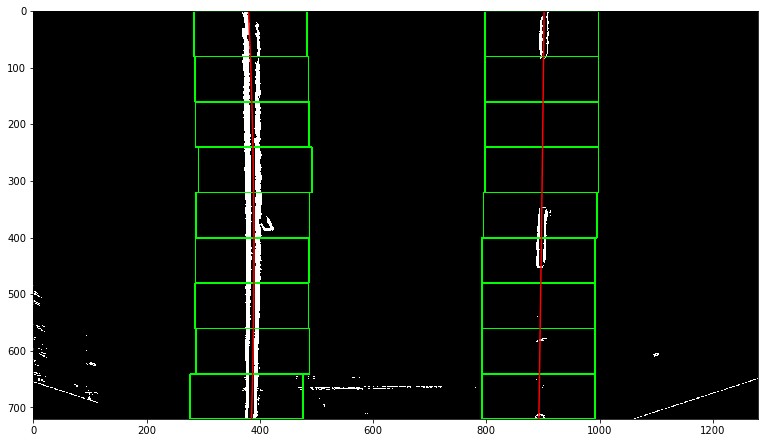

In [25]:
# Generate x and y values for plotting
ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

fig = plt.figure(figsize=(15,7.5))
plt.imshow(out)
plt.plot(left_fitx, ploty, color='red')
plt.plot(right_fitx, ploty, color='red')
plt.xlim(0, 1280)
plt.ylim(720, 0)

Calculate curvature for both lanes

In [26]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/520 # meters per pixel in x dimension

y_eval = 720
# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(left_ys*ym_per_pix, left_xs*xm_per_pix, 2)
right_fit_cr = np.polyfit(right_ys*ym_per_pix, right_xs*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

2331.84772546 m 33453.8322886 m


Calculate relative car position to lane center

In [27]:
d, o = car_position_offset(img.shape, left_fit, right_fit, xm_per_pix)
print(d,o)

left 0.00691812604766


Visualize lane fitting

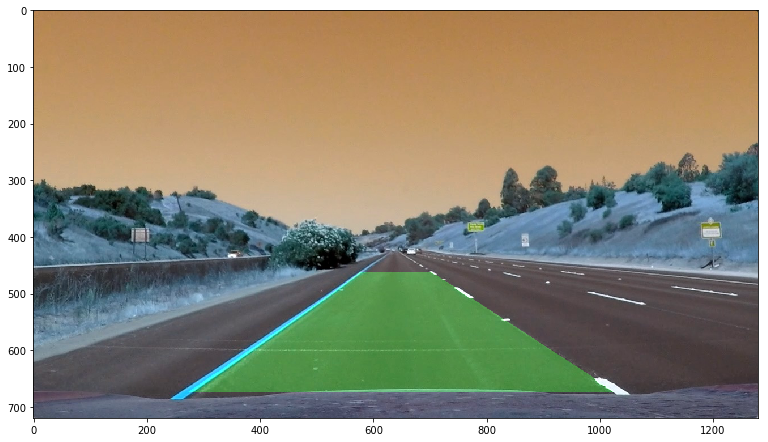

In [29]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped[..., 0]).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(cv2.imread(img_list[0]), 1, newwarp, 0.3, 0)
fig = plt.figure(figsize=(15,7.5))
plt.imshow(result)

# Pipeline with example pictures 

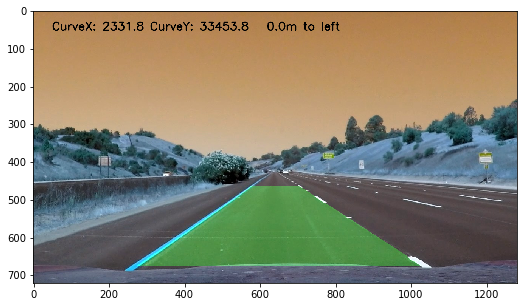

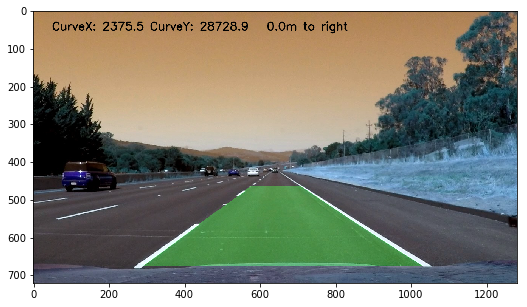

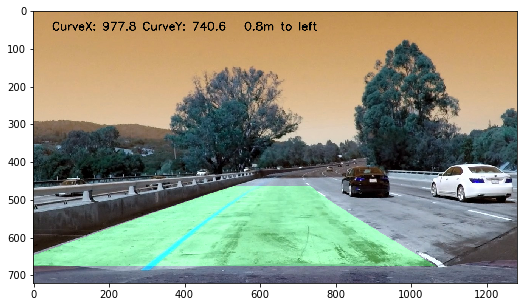

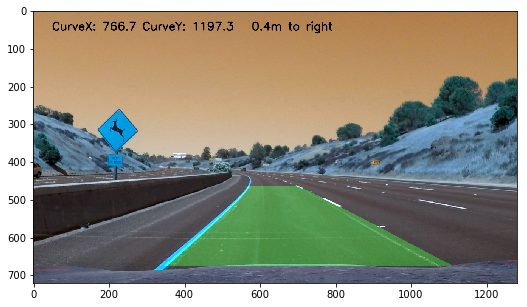

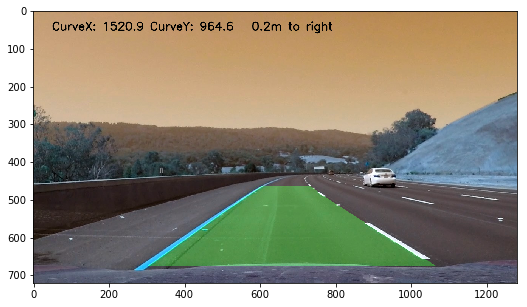

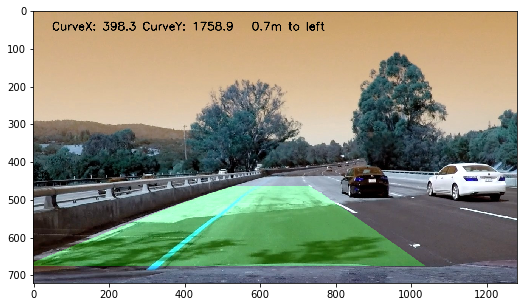

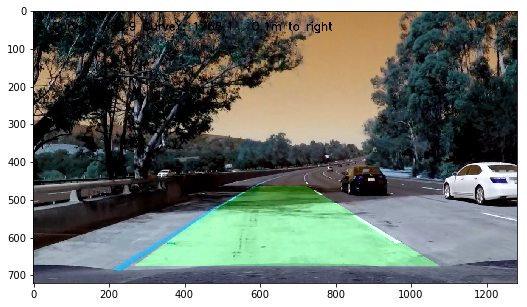

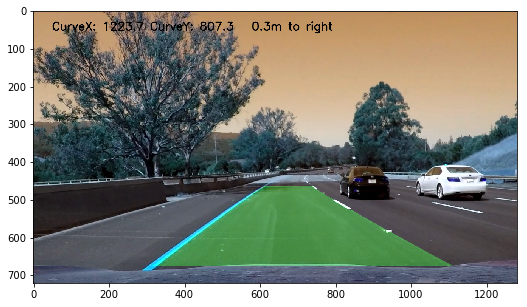

In [33]:
img_list = sorted(glob.glob('./test_images/*.jpg'))
for i, file in enumerate(img_list):
    img = cv2.imread(file)
    out_img = pipeline(img)
    fig = plt.figure(i, figsize=(10, 5))
    plt.imshow(out_img)